In [9]:
import requests
import pandas as pd
from datetime import datetime, timedelta

### Data Acquisition and Label the data

In [10]:
# Cities with lat/lon
cities = {
    0: (13.0827, 80.2707),  # Chennai
    1: (28.6139, 77.2090),  # Delhi
    2: (19.0760, 72.8777),  # Mumbai
    3: (12.9716, 77.5946),  # Bangalore
    4: (17.3850, 78.4867)   # Hyderabad
}

# Date range for past 1 year
end_date = (datetime.today() - timedelta(days=1)).date()
start_date = end_date - timedelta(days=360)

# Base URL and parameters for hourly data
base_url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "hourly": "temperature_2m,relative_humidity_2m,pressure_msl,windspeed_10m,weathercode",
    "timezone": "auto"
}

# Collect all data
all_data = []

for city, (lat, lon) in cities.items():
    print(f"📦 Fetching hourly data for {city}...")
    
    response = requests.get(base_url, params={
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        **params
    })

    data = response.json()
    
    if "hourly" in data:
        df = pd.DataFrame(data["hourly"])
        df["city"] = city
        
        # Drop rows with any missing values (NaN)
        df.dropna(inplace=True)
        
        all_data.append(df)
    else:
        print(f"No data found for {city}.")

# Combine and save
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df.to_csv("hourly_weather_data.csv", index=False)
    print("Saved as clean_hourly_weather_data.csv")
else:
    print("No data was collected.")

📦 Fetching hourly data for 0...
📦 Fetching hourly data for 1...
📦 Fetching hourly data for 2...
📦 Fetching hourly data for 3...
📦 Fetching hourly data for 4...
Saved as clean_hourly_weather_data.csv


Data Labeling

In [11]:
import pandas as pd

# Load your CSV
df = pd.read_csv("hourly_weather_data.csv")

# Function to convert weathercode to label
def label_weather(code):
    if code == 0:
        return 0
    elif code in [1, 2, 3, 45, 48]:
        return 1
    else:
        return 2

# Apply the function to create a new 'label' column
df["label"] = df["weathercode"].apply(label_weather)

# Save the labeled data
df.to_csv("hourly_weather_data_labeled.csv", index=False)
print("✅ Labeled data saved to 'hourly_weather_data_labeled.csv'")

✅ Labeled data saved to 'hourly_weather_data_labeled.csv'


### Exploratory Data Analysis (EDA)

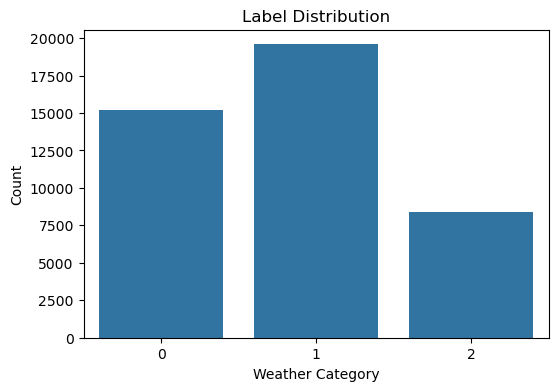

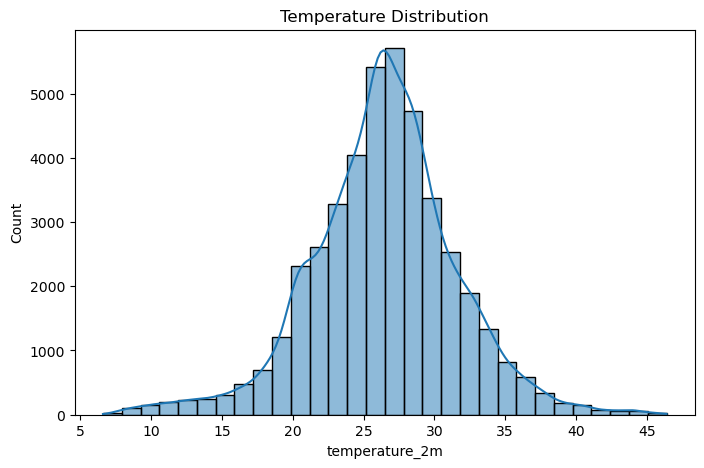

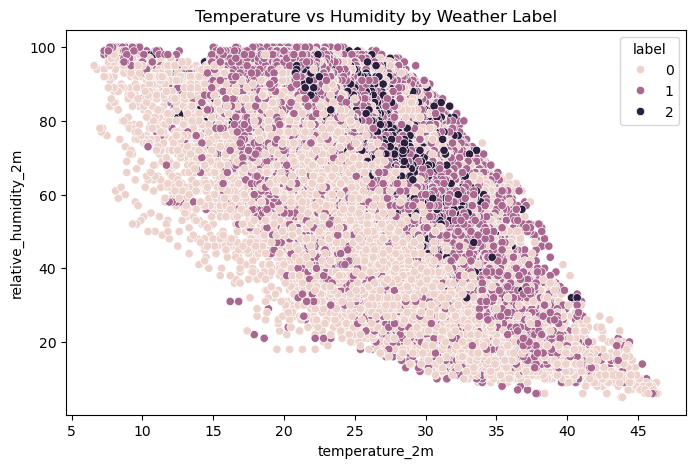

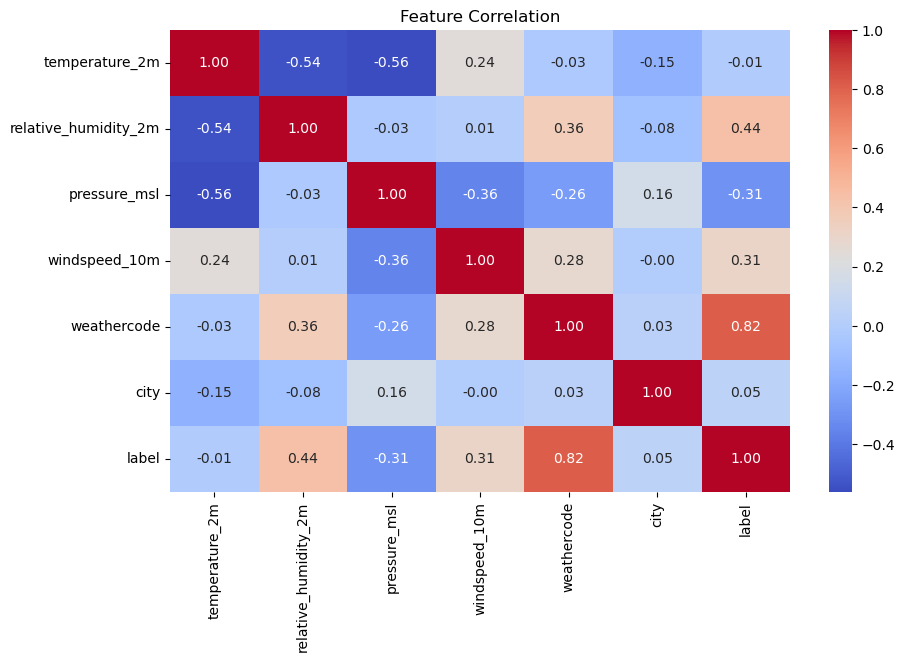

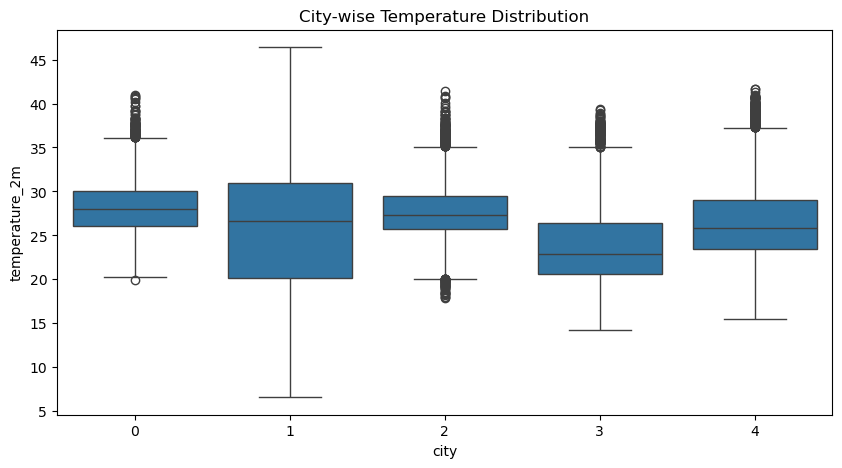

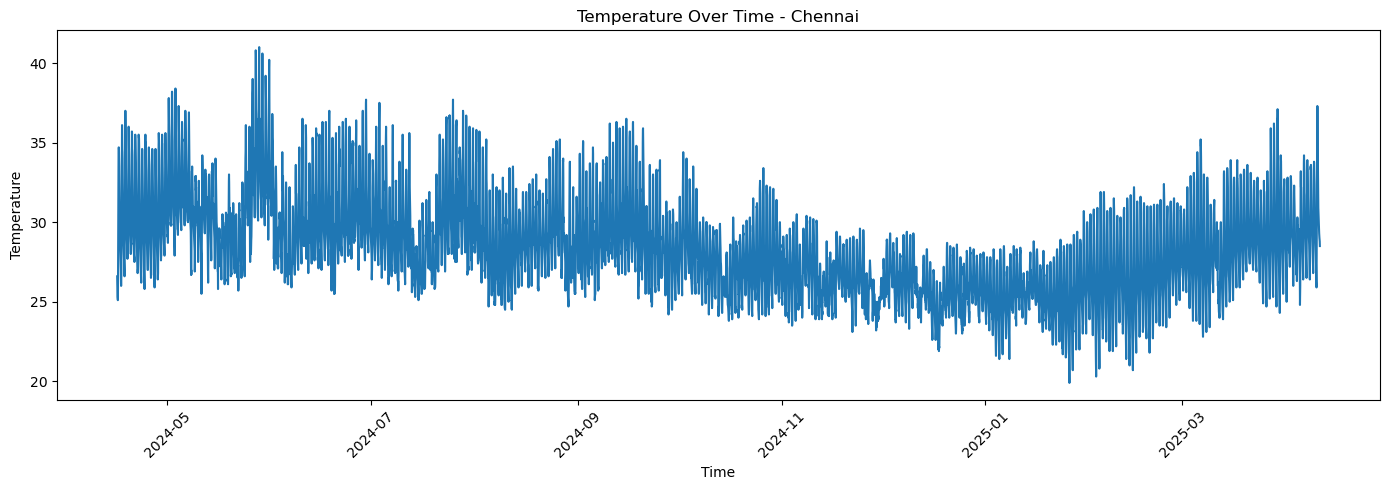

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("hourly_weather_data_labeled.csv")

# # BASIC INFO
# print(" Dataset Info:")
# print(df.info())
# print(" Basic Statistics:")
# print(df.describe())

# # MISSING VALUES
# print(" Missing Values:")
# print(df.isnull().sum())

# LABEL DISTRIBUTION
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Label Distribution")
plt.xlabel("Weather Category")
plt.ylabel("Count")
plt.show()

# TEMPERATURE DISTRIBUTION
plt.figure(figsize=(8, 5))
sns.histplot(df["temperature_2m"], kde=True, bins=30)
plt.title("Temperature Distribution")
plt.show()

# SCATTER PLOT: Temp vs Humidity
plt.figure(figsize=(8, 5))
sns.scatterplot(x="temperature_2m", y="relative_humidity_2m", hue="label", data=df)
plt.title("Temperature vs Humidity by Weather Label")
plt.show()

#  CORRELATION HEATMAP
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation")
plt.show()

# CITY-WISE TEMPERATURE BOXPLOT
plt.figure(figsize=(10, 5))
sns.boxplot(x="city", y="temperature_2m", data=df)
plt.title("City-wise Temperature Distribution")
plt.show()

# TIME SERIES EXAMPLE
df['time'] = pd.to_datetime(df['time'])
sample_city = df[df['city'] == 0]
plt.figure(figsize=(14, 5))
plt.plot(sample_city['time'], sample_city['temperature_2m'], label="Temperature")
plt.title("Temperature Over Time - Chennai")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Data Preprocessing and Feature Engineering 

In [13]:
import pandas as pd

dataset = pd.read_csv('hourly_weather_data_labeled.csv')
dataset.head()

dataset.info()

dataset.isnull().sum()

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

# X.head()

X = X.drop(columns=["time", "weathercode"])

X.head(), y.head(), X.info()

y.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43230 entries, 0 to 43229
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  43230 non-null  object 
 1   temperature_2m        43230 non-null  float64
 2   relative_humidity_2m  43230 non-null  float64
 3   pressure_msl          43230 non-null  float64
 4   windspeed_10m         43230 non-null  float64
 5   weathercode           43230 non-null  float64
 6   city                  43230 non-null  int64  
 7   label                 43230 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 2.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43230 entries, 0 to 43229
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature_2m        43230 non-null  float64
 1   relative_humidity_2m  43230 non-null  float64
 2   pre

label
1    19583
0    15227
2     8420
Name: count, dtype: int64

### Handling Class Imbalance with SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="label")], axis=1)

print(df_resampled["label"].value_counts())

df_resampled.describe()

df_resampled.shape, df_resampled['label'].value_counts()

# Split features and Labels

X = df_resampled.iloc[:, :-1]
y = df_resampled.iloc[:, -1]

X.shape, y.shape, type(X), X.head()

label
0    19583
1    19583
2    19583
Name: count, dtype: int64


((58749, 5),
 (58749,),
 pandas.core.frame.DataFrame,
    temperature_2m  relative_humidity_2m  pressure_msl  windspeed_10m  city
 0            26.6                  91.0        1011.4            4.5     0
 1            26.1                  94.0        1010.6            4.6     0
 2            25.6                  96.0        1010.0            6.2     0
 3            25.3                  97.0        1009.8            6.6     0
 4            25.2                  97.0        1010.1            7.3     0)

### Creating Time Series Sequences

In [15]:
import numpy as np

def create_sequences(X, y, window_size, forecast_horizon):
    Xs, ys = [], []
    for i in range(len(X) - window_size - forecast_horizon + 1):
        Xs.append(X.iloc[i : i + window_size].values)          # past 120 hours
        ys.append(y.iloc[i + window_size : i + window_size + forecast_horizon].values) # next 120 hours
    return np.array(Xs), np.array(ys)

# Parameters
window_size = 120 
forecast_horizon = 120 

# Create sequences
X_seq, y_seq = create_sequences(X, y, window_size, forecast_horizon)

print("X_seq shape:", X_seq.shape)  # (samples, 120, num_features)
print("y_seq shape:", y_seq.shape)  # (samples, 120)


X_seq shape: (58510, 120, 5)
y_seq shape: (58510, 120)


### Train-Test Split and One-Hot Encoding

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# One-hot encode y_train and y_test after splitting
num_classes = 3
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print("Before:", y_train.shape)
print("After:", y_train_cat.shape)

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

Before: (46808, 120)
After: (46808, 120, 3)
{0: 1884805, 1: 1864395, 2: 1867760}


### Feature Scaling 

In [17]:
from sklearn.preprocessing import StandardScaler

# Flatten for scaling
num_samples, timesteps, num_features = X_train.shape
X_train_2d = X_train.reshape(-1, num_features)  # shape: (num_samples * timesteps, features)
X_test_2d = X_test.reshape(-1, num_features)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

# Reshape back
X_train = X_train_scaled.reshape(num_samples, timesteps, num_features)
X_test = X_test_scaled.reshape(X_test.shape[0], timesteps, num_features)

X_train.shape

(46808, 120, 5)

### Model Building and Training (LSTM Model)

In [18]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed, RepeatVector,  LSTM
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

num_classes = 3

# model1 = Sequential()
# model1.add(GRU(128, input_shape=(120, X.shape[1])))
# model1.add(RepeatVector(120))
# model1.add(GRU(128, return_sequences=True))
# model1.add(Dropout(0.3))
# model1.add(TimeDistributed(Dense(64, activation='relu')))
# model1.add(TimeDistributed(Dense(num_classes, activation='softmax')))

model1 = Sequential()
model1.add(LSTM(128, input_shape=(120, X.shape[1]), return_sequences=True))
model1.add(Dropout(0.5))
model1.add(LSTM(128, return_sequences=True))
model1.add(Dropout(0.5))
model1.add(TimeDistributed(Dense(64, activation='relu')))
model1.add(TimeDistributed(Dense(num_classes, activation='softmax')))


optimizer = Adam(learning_rate=0.0001)

model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
result1 = model1.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=20, batch_size=32)

c:\Users\Vignesh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
  50/1463 ━━━━━━━━━━━━━━━━━━━━ 5:15 223ms/step - accuracy: 0.4902 - loss: 1.0375

KeyboardInterrupt: 

In [11]:
model1.save("model_1.h5")
joblib.dump(scaler, "model_1.pkl")

['model_1.pkl']

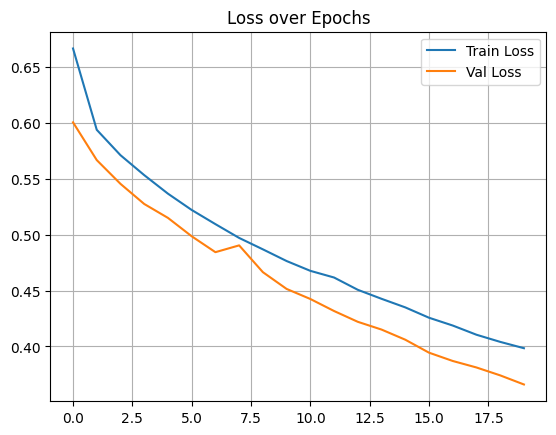

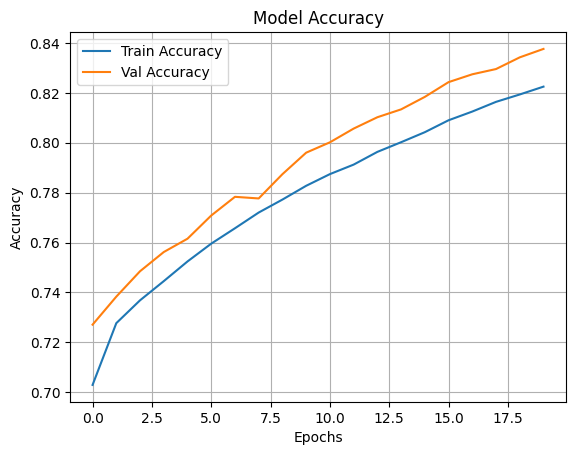

In [12]:
plt.plot(result1.history['loss'], label='Train Loss')
plt.plot(result1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.grid()
plt.show()

# Plot Accuracy
plt.plot(result1.history['accuracy'], label='Train Accuracy')
plt.plot(result1.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### Prediction

In [7]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model
import joblib

# Load your model and scaler
model = load_model("model_1_rainy_sunny_cloudy.h5")
scaler = joblib.load("model_1_scaler.pkl")

# cities = {
#     0: (13.0827, 80.2707),  # Chennai
#     1: (28.6139, 77.2090),  # Delhi
#     2: (19.0760, 72.8777),  # Mumbai
#     3: (12.9716, 77.5946),  # Bangalore
#     4: (17.3850, 78.4867)   # Hyderabad
# }

# Delhi coordinates
lat, lon =13.0827, 80.2707
city_code = 0

# Get today's and next 5 days date for next 120 hours
start_time = datetime.utcnow().replace(minute=0, second=0, microsecond=0)
end_time = start_time + timedelta(hours=120)

# Open-Meteo API URL
url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={lat}&longitude={lon}&hourly=temperature_2m,relative_humidity_2m,"
    f"pressure_msl,windspeed_10m,weathercode&timezone=UTC"
    f"&start_date={start_time.date()}&end_date={end_time.date()}"
)

# Send GET request
response = requests.get(url)
data = response.json()

# Extract hourly data
hourly = data['hourly']
df = pd.DataFrame(hourly)
df['time'] = pd.to_datetime(df['time'])

# Get first 120 rows (to use as input)
df = df.sort_values('time').head(120).reset_index(drop=True) #changed tail to head
df['city'] = city_code
features = df[['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'windspeed_10m', 'city']]

# Scale the features
features_scaled = scaler.transform(features)

# Reshape for model input
X_input = features_scaled.reshape(1, 120, 5)

# Predict next 120 hours (as classification per hour)
y_pred_proba = model.predict(X_input)
y_pred_classes = np.argmax(y_pred_proba, axis=-1)[0]

# Map predictions to weather labels
label_map = {0: "Sunny", 1: "Cloudy", 2: "Rainy"}
predicted_labels = [label_map[i] for i in y_pred_classes]

# Add predictions to dataframe
df['Predicted_Weather'] = predicted_labels

# Print the next 5-day forecast
print(df[['time', 'Predicted_Weather']].tail(120))
print(df['Predicted_Weather'].value_counts())
# print(y_pred_proba) #print the probabilities.
# print(features_scaled) #print the scaled input features.

# Save predictions to a CSV file
df[['time', 'Predicted_Weather']].to_csv("5_day_weather_forecast.csv", index=False)
print("Forecast saved to 5_day_weather_forecast.csv")

c:\Users\Vignesh\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Vignesh\AppData\Local\Temp\ipykernel_6476\508448697.py:25: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow().replace(minute=0, second=0, microsecond=0)
c:\Users\Vignesh\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                   time Predicted_Weather
0   2025-04-12 00:00:00            Cloudy
1   2025-04-12 01:00:00            Cloudy
2   2025-04-12 02:00:00            Cloudy
3   2025-04-12 03:00:00            Cloudy
4   2025-04-12 04:00:00            Cloudy
..                  ...               ...
115 2025-04-16 19:00:00            Cloudy
116 2025-04-16 20:00:00            Cloudy
117 2025-04-16 21:00:00            Cloudy
118 2025-04-16 22:00:00            Cloudy
119 2025-04-16 23:00:00            Cloudy

[120 rows x 2 columns]
Predicted_Weather
Cloudy    116
Sunny       4
Name: count, dtype: int64
Forecast saved to 5_day_weather_forecast.csv


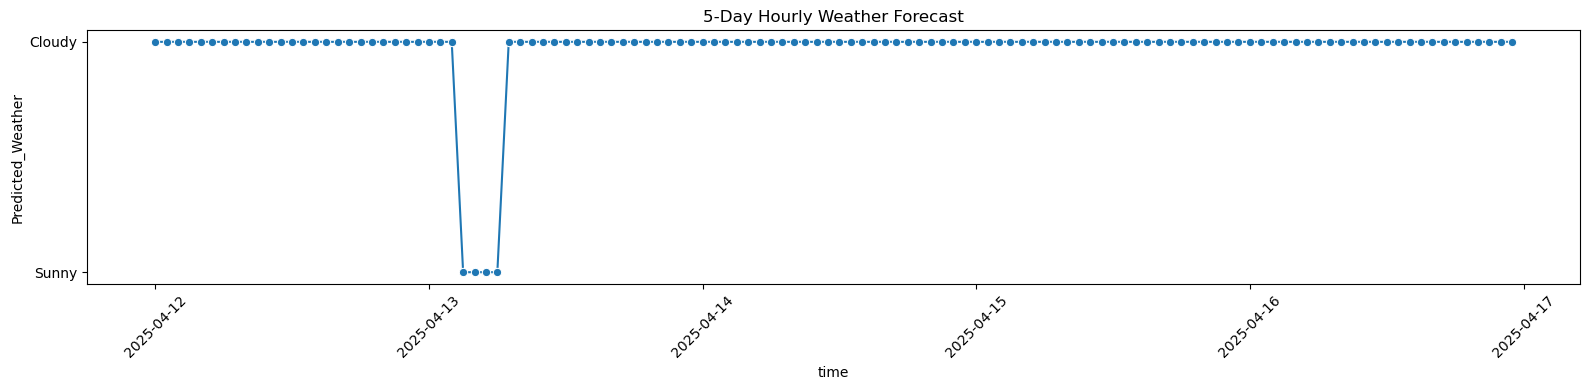

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
sns.lineplot(x=df['time'], y=df['Predicted_Weather'], marker='o')
plt.xticks(rotation=45)
plt.title("5-Day Hourly Weather Forecast")
plt.tight_layout()
plt.show()
